# Installation
If you already have the python package pyfftw installed, you should not need to install ultrafastultrafast in order to run this notebook.  If you do want to install the code, see README for instructions (installing ultrafastultrafast should also install pyfftw).

In [1]:
%matplotlib notebook
import ultrafastultrafast as uf2
import numpy as np
import matplotlib.pyplot as plt
import yaml
import os

# RKE
RKE is a method for solving for the perturbative wavepackets of the full Hamiltonian
$$H = H_0 -\boldsymbol{\mu}\cdot \boldsymbol{E}(t)$$
using time-dependent perturbation theory (TDPT). Bold-face symbols are cartesian vectors.

RKE is based upon a hybrid algorithm that uses scipy's RK45 function to handle system dynamics, and the first-order Euler method to handle perturbations due to ultrafast optical pulses.  For details of the implementation see our Appendix B of our paper in JCP: https://doi.org/10.1063/1.5094062.

The fundamental building block of this code is the class uf2.RKE_Wavepackets, which implements methods named "up" and "down", and can be used to calculate the wavepackets associated with any Feynman diagram.  See section Example Diagram below for an example of calculating a single diagram.  See section Signals below for examples of calculating full nonlinear optical signals.

## Unperturbed Hamiltonian H_0
RKE should be compatible with any time-independent unperturbed Hamiltonian that can be expressed in some basis as a matrix, so that the unperturbed dynamics are a set of ordinary differential equations (ODEs) in the form
$$\frac{d|\psi\rangle}{dt} = H_0|\psi\rangle$$

In practice, RKE relies on the assumption that there are optically separated manifolds, so that $H_0$ is block diagonal with at least two blocks: the ground-state manifold (GSM) and the singly excited manifold (SEM).  There can be more manifolds.  RKE is compatible with $n^{th}$-order spectroscopies, the most common of which are $3^{rd}$-order spectroscopies such as Transient Absorption, 2D photon echo, double quantum, and others.  Such spectroscopies are sensitive only to the GSM, SEM and doubly excited manifold (DEM).  Currently, this implementation only handles up to the DEM.

In order to give an example of RKE, we include a package in the folder vibronic_eigenstates which has code for generating vibronic Hamiltonians.  In order to use this code, you must make a new, empty folder, and place in it a file called simple_params.yaml.  We include a folder called dimer_example which includes the simple_params.yaml file that describes two coupled two-level systems, each with a linearly coupled vibrational mode.  The parameter file can be viewed and edited in a text editor, and the contents are displayed here

In [2]:
file_path = 'dimer_example'

In [3]:
with open(os.path.join('dimer_example','simple_params.yaml')) as yamlstream:
    simple_params = yaml.load(yamlstream)
for key in simple_params.keys():
    print(key,simple_params[key])

site_energies [0, 0.75]
site_couplings [0.3307]
vibrations [{'omega_g': 1.0, 'displacement': 0.2, 'site_label': 0, 'reorganization': 0}, {'omega_g': 1.000001, 'displacement': 0.2, 'site_label': 1, 'reorganization': 0}]
dipoles [[1, 0, 0], [0, 1, 0]]
num_eigenvalues full
eigenvalue_precision 0.1
truncation_size 5


To convert this simple parameters file, which is much more user-friendly than the parameters file actually required by the code, we provide a converter:

In [6]:
uf2.vibronic_eigenstates.convert(file_path)

The folder dimer_example should now contain the file params.yaml.  This file can also be opened in a text editor, and is the true parameter file to describe $H_0$.  Advanced users can edit this file directly to gain more control over $H_0$. Note: currently there is no documentation to describe how this works.  Coming soon!

Important: the file params.yaml must exist in the folder in order to run RKE

In order to use this code, you must specify the file_path variable to a folder you create

## Example Diagram
Here is an example of how to use the algorithm to calculate the SE contribution of a pump-probe experiment.  We begin by specifying the relevant electric fields. Note that RKE does not require analytical pulse shapes.  It simply requires that a pulse be defined on a regular time grid with $M$ points spaced by spacing $dt$.  We use Gaussian pulses here as an example.

In [7]:
def pump(t,sigma):
    """Define pump field"""
    return 1/np.sqrt(2*np.pi)/sigma*np.exp(-t**2/(2*sigma**2))

def probe(t,sigma):
    """Define the probe field"""
    return 1/np.sqrt(2*np.pi)/sigma*np.exp(-t**2/(2*sigma**2))

## Units
Units are expressed in terms of an angular frequency $\omega_0$, usually the frequency of the slowest vibrational frequency in the GSM.  All times are expressed in units of $\omega_0^{-1}$, and all frequencies are expressed in units of $\omega_0$.

In [8]:
# Define the pump and probe amplitude functions.  Note that both should be defined centered at t = 0

pump_sigma = 0.8 # in units of omega_0^-1
probe_sigma = 1 # in units of omega_0^-1

# Define the time grid on which the electric fields are to be evaluated
dt = 0.1 # in units of omega_0^-1, time spacing required to resolve all pulse shapes
M = 100 # in units of omega_0^-1, number of points required to resolve all pulse shapes

# Define the time grid on which the wavefunctions will be expressed
total_t = int(200/dt) # in units of omega_0^-1, total number of time points - 
                      # must span from 0 to 5/gamma beyond last delay time point

wp = uf2.RK_Wavepackets(file_path,dt=dt,num_conv_points=M,total_num_time_points=total_t)

# The value of M and dt specified create an array of time points that must be used to evaluate the electric field
# That array is stored inside of the Wavepackets object with attribute efield_t

# pu and pr do not need to be evaluated using an analytical pulse function
pu = pump(wp.efield_t,pump_sigma) # Could be a numpy array of M points describing an arbitrary pulse shape
pr = probe(wp.efield_t,probe_sigma) # Could be a numpy array of M points describing an arbitrary pulse shape

# Pump-probe spectroscopy is calculated to lowest order as four-wave mixing
# where the pump provides the first two interactions, and the probe
# provides the third interaction, and acts as the "fourth interaction" in 
# the form of the local oscillator

wp.efields = [pu,pu,pr,pr]

# The pump is polarized along the 'x' direcetion
# The probe is polarized along the same direction

wp.set_polarization_sequence(['x','x','x','x'])

# Set gamma - effective optical dephasing rate
wp.set_homogeneous_linewidth(0.05)

<IPython.core.display.Javascript object>


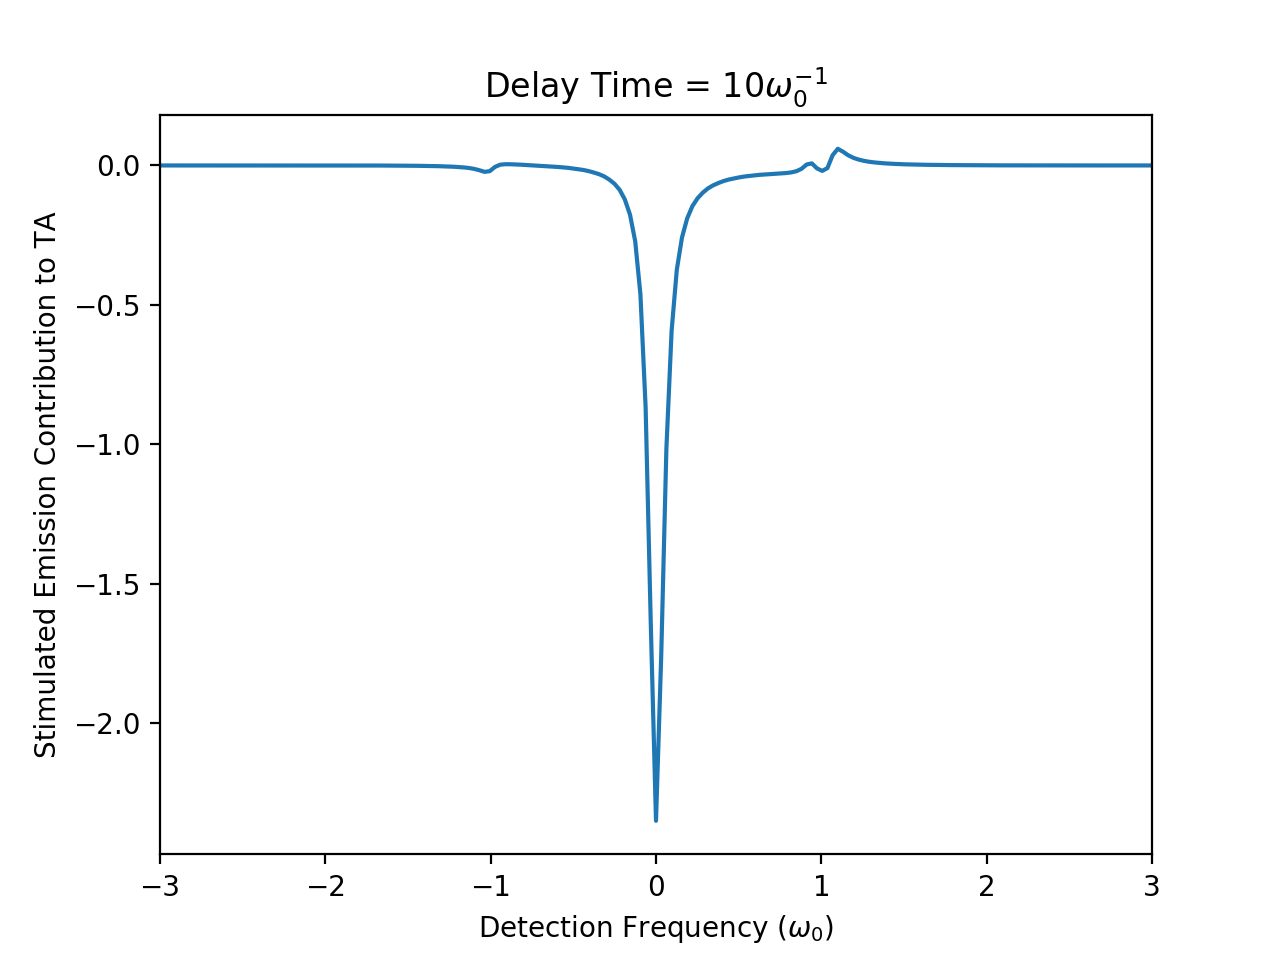

Text(0.5,1,'Delay Time = 10$\\omega_0^{-1}$')

In [9]:
# Create the wavepackets needed for the SE signal at the specified delay time

delay_time = 10

# Using this delay time, set the interaction times for each of the four interactions
# in the form [pump_time, pump_time, probe_time, probe_time]

wp.pulse_times = [0,0,delay_time,delay_time]

# Construct Perturbative Wavepackets

psi_b = wp.up(wp.psi0,pulse_number = 1)
psi_a = wp.up(wp.psi0,pulse_number = 0)
psi_ac = wp.down(psi_a,pulse_number = 2)

# Calculate the SE contribution to the resulting frequency-resolved spectrum at the specified delay time

# The time-dependent polarization field is the expectation value of the perturbed wavepackets and
# the dipole operator

SE_polarization = wp.dipole_expectation(psi_ac,psi_b)

# Finally convert that polarization into a heterodyne-detected signal

SE_signal = wp.polarization_to_signal(SE_polarization)

# The frequency-detected signal for this value of delay time is plotted here

plt.figure()
plt.plot(wp.w,SE_signal)
plt.xlim([-3,3])
plt.xlabel('Detection Frequency ($\omega_0$)')
plt.ylabel('Stimulated Emission Contribution to TA')
plt.title('Delay Time = {}'.format(delay_time) + '$\omega_0^{-1}$')

## Signals
There are four files located in the signals sub-directory that show examples of how to use uf2 to implement various $n$-wave mixing signals

### Transient Absorption

The file TA_example.py includes a class, TransientAbsorption, that calculates all of the required diagrams for the transient absorption signal using uf2.Wavepackets.  An example of using that class is given here.  To see how all of the diagrams are coded and combined into one signal, please see the code.

In [10]:
pump_sigma = 0.2
probe_sigma = 0.2
dt = min(pump_sigma,probe_sigma)/2
M = 21
total_t = int(200/dt)

<IPython.core.display.Javascript object>


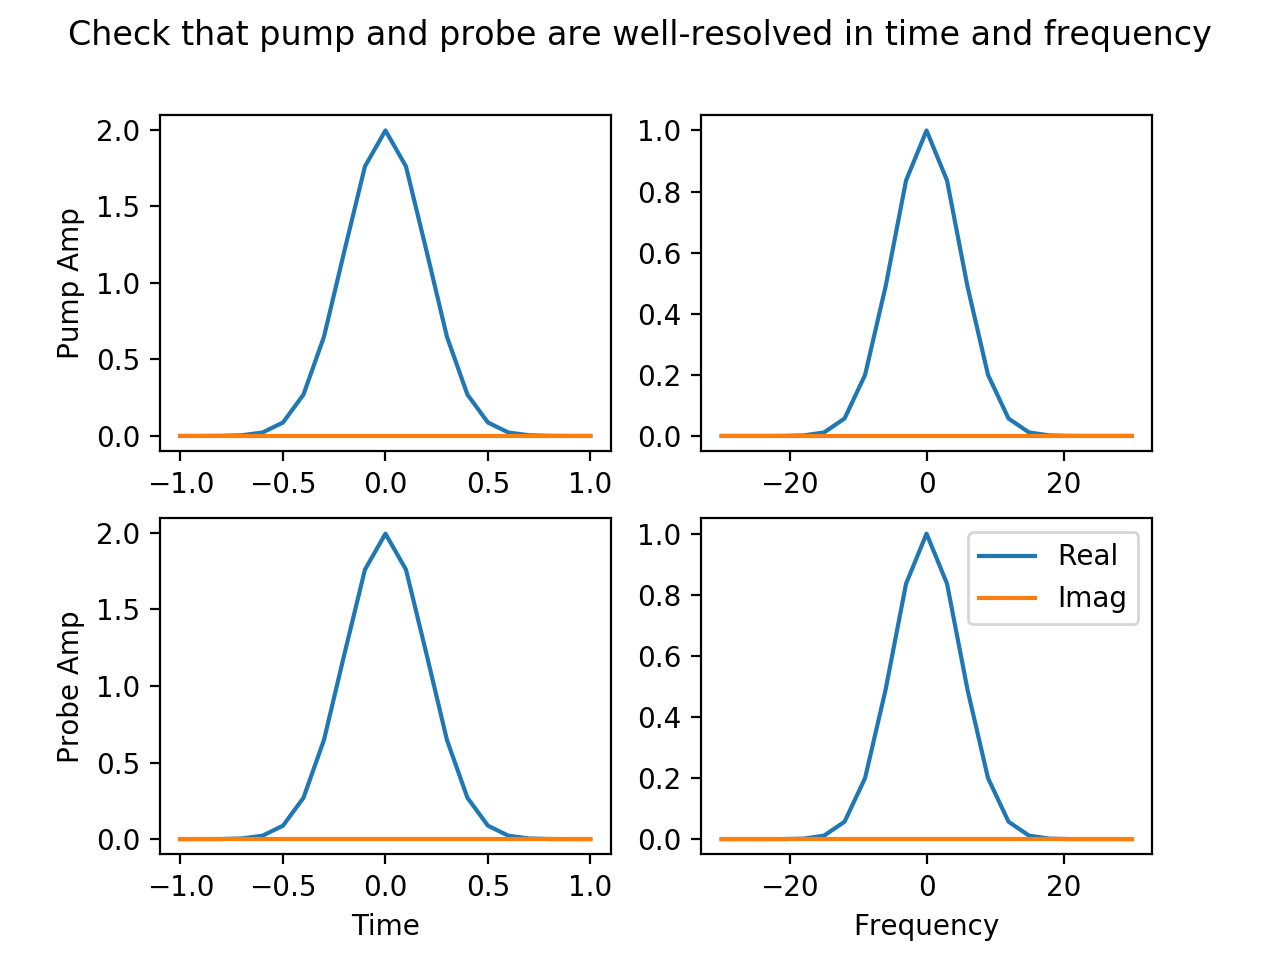

In [11]:
# Initialize object with filepath to saved eigenvalues and dipole operator
ta = uf2.signals.RK_TransientAbsorption(file_path,dt=dt,num_conv_points=M,total_num_time_points=total_t)

# As before, signal fields and polarization sequence must be set

pu = pump(ta.efield_t,pump_sigma) #Using above Gaussian field definition
pr = probe(ta.efield_t,probe_sigma) #Using above Gaussian field definition

# The class TransientAbsorption has a method for setting the four interaction fields given the pump shape and the
# probe shape

ta.set_pulse_shapes(pu,pr)

# The pump is polarized along the 'x' direcetion
# The probe is polarized along the same direcetion

pol_seq = ['x','x','x','x']

ta.set_polarization_sequence(pol_seq)

<IPython.core.display.Javascript object>


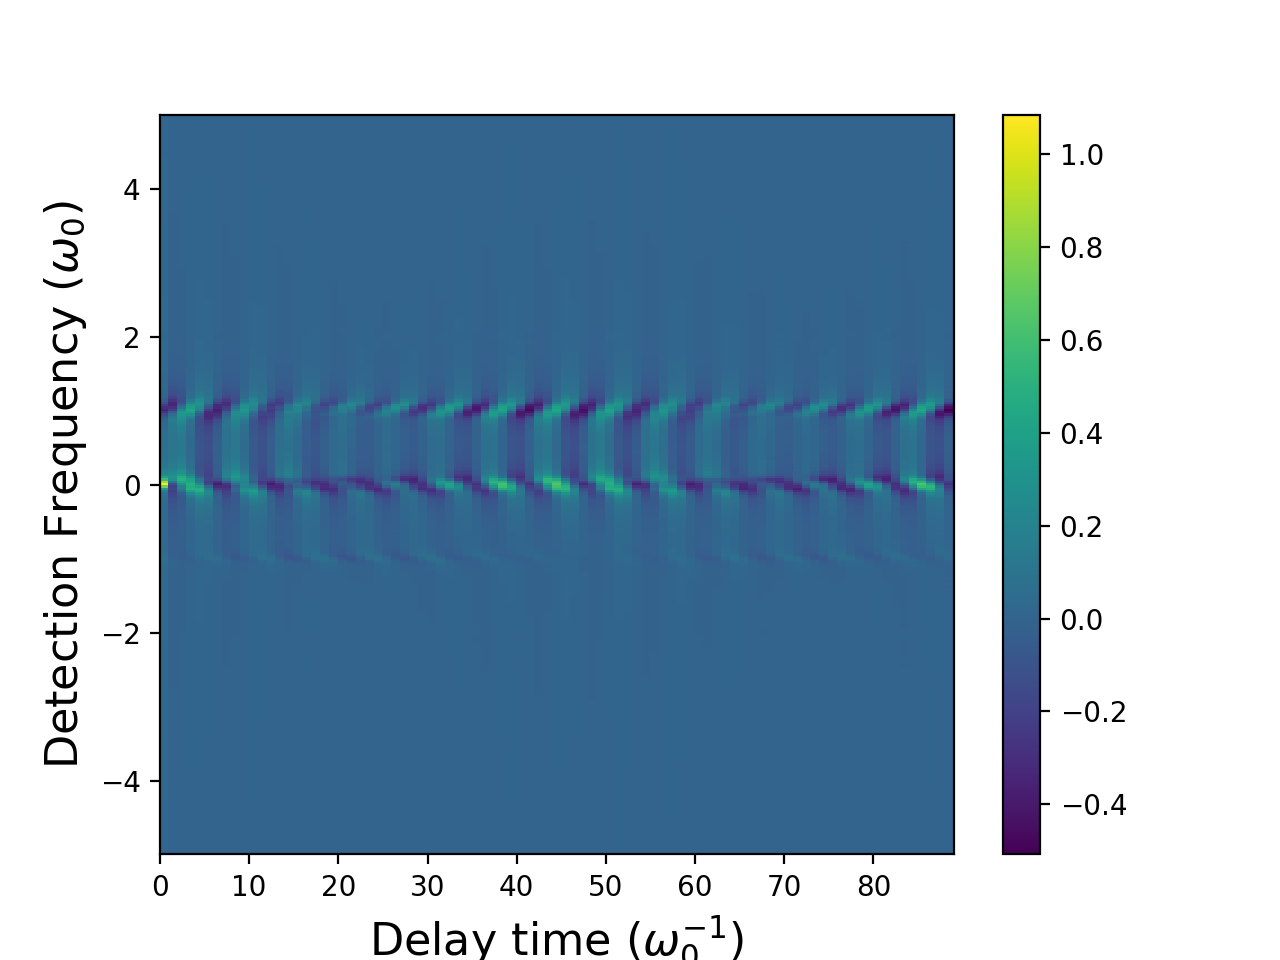

In [16]:
# Pick delay times of interest.  The code is written in such a way that negative delay times cannot be calculated. 
# This is a limitation of the implementation, not of the method
delay_times = np.arange(0,90,1) #delay times must coincide with time mesh calculation is performed on

# The class TransientAbsorption includes all necessary diagrams for calculating the TA signal

spectra = ta.calculate_pump_probe_spectra_vs_delay_time(delay_times)
ta.save_pump_probe_spectra_vs_delay_time()
ta.plot_pump_probe_spectra(frequency_range = [-5,5],subtract_DC=True,save_fig=True)

#### Isotropic Averaging

RKE does not have an implementation of Isotropic Averaging.  However, it uses the same API as $\text{UF}^2$, so doing so should be quite straightforward.